In [336]:
import pystan
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import arviz as az
import csv
import scipy
import matplotlib.colors as colors

# Algotrading Data

In [337]:
# compute mean and var for each day 
days = {'Sunday':
            [1.0883, 1.1071, 1.0943, 1.1089, 1.1629, 1.0994, 1.1022, 1.1364, 1.0903,
            1.1153, 1.097, 1.0978, 1.1393, 1.1653, 1.1104, 1.1099, 1.119, 1.0983,
            1.1145, 1.1225, 1.1196, 1.1165, 1.0868, 1.1154, 1.1494, 1.1467, 1.1457,
            1.0982, 1.098, 1.1299, 1.1162, 1.079, 1.1523],
        'Monday':
            [1.0426, 1.0589, 1.0564, 1.0509, 1.0745, 1.0509, 1.0609, 1.0691, 1.0632,
            1.0627, 1.0699, 1.0496, 1.0582, 1.0643, 1.0741, 1.0551, 1.0681, 1.0538,
            1.0657, 1.0581, 1.0471, 1.066, 1.0631, 1.0764, 1.0787, 1.059, 1.0383,
            1.0685, 1.0773, 1.0644, 1.068, 1.062, 1.077, 1.0622, 1.0764],
        'Tuesday':
            [1.0779, 1.0873, 1.092, 1.0805, 1.0971, 1.0823, 1.0857, 1.0797,
            1.0872, 1.0874, 1.1113, 1.1012, 1.0961, 1.0983, 1.0952, 1.0862,
            1.1066, 1.077, 1.093, 1.0867, 1.0851, 1.0907, 1.1207, 1.1011,
            1.0717, 1.0948, 1.1004, 1.0908, 1.0825, 1.0797, 1.0776, 1.0876,
            1.0795, 1.1051, 1.093, 1.1152, 1.0992, 1.0975, 1.1008, 1.1158,
            1.0933, 1.0948, 1.1047, 1.1025, 1.0936, 1.1072, 1.0844, 1.0954, 1.1066]}

# Y is the mean 
# sigma is the variance 
# J = 3
J = len(days.keys())
Y = np.zeros(J)
sigma = np.zeros(J)
for i,day in enumerate(days): 
    Y[i] = np.mean(days[day]) 
    sigma[i] = np.std(days[day])
    
print("sigma:", sigma)
print("mean:", Y)

schools_dat = {'J': J,
               'y': Y,
               'sigma': sigma}

Y = np.array(schools_dat['y'])
#data = np.array(schools_dat['y'])
sigma = np.array(schools_dat['sigma'])

sigma: [0.02238639 0.00995762 0.01100427]
mean: [1.11614545 1.06261143 1.09346939]


# HW2 - Hier (Cauchy prior)

In [338]:
model_1 = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    tau ~ cauchy(0, 5);
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

In [339]:
sm1 = pystan.StanModel(model_code=model_1)
fit_m1 = sm1.sampling(data=schools_dat, iter=10000, chains=4)
print(fit_m1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46353e9f4ed5b0d250403514d230955a NOW.


Inference for Stan model: anon_model_46353e9f4ed5b0d250403514d230955a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         1.09  4.1e-3   0.04   1.02   1.07   1.09    1.1   1.17     82   1.05
tau        0.07  7.9e-3   0.07 5.6e-3   0.02   0.04   0.09   0.29     77   1.03
eta[1]     0.41    0.03   0.71  -0.87  -0.06   0.35   0.86    1.9    755    1.0
eta[2]    -0.59    0.03    0.7  -2.13  -1.01  -0.56  -0.04   0.58    732   1.01
eta[3]     0.13    0.02   0.64  -1.06  -0.32   0.15   0.51   1.49    822   1.01
theta[1]   1.11  4.1e-4   0.02   1.07   1.09   1.11   1.12   1.15   2663    1.0
theta[2]   1.07  1.4e-4   0.01   1.05   1.06   1.07   1.07   1.09   5426    1.0
theta[3]   1.09  3.1e-4   0.01   1.07   1.08   1.09    1.1   1.11   1223    1.0
lp__      -5.64    0.12   2.29 -11.09   -6.9   -5.3  -4.05  -2.03    386    1.0

Samples 

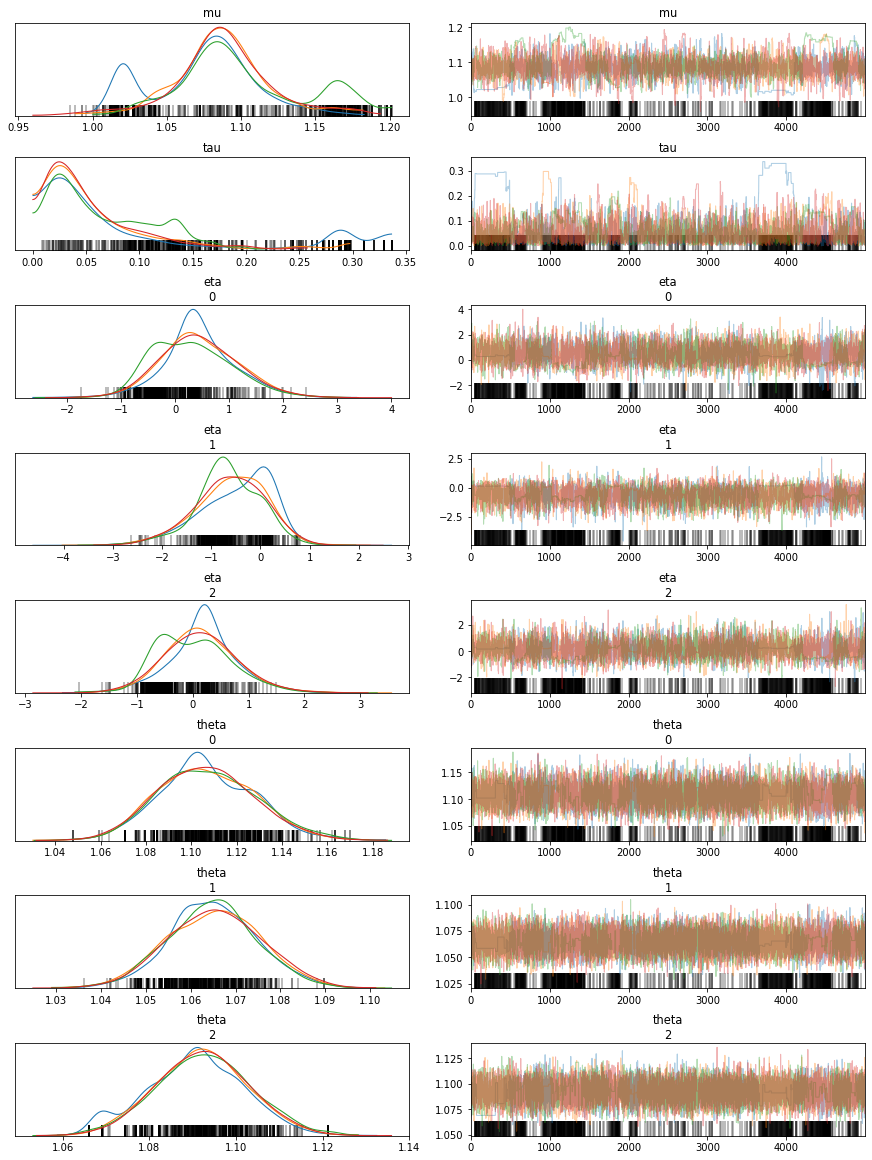

In [340]:
_ = az.plot_trace(fit_m1)

In [341]:
fit_m1.extract(permuted = True)
mu_m1 = np.array(fit_m1.extract()['mu'])
tau_m1 = np.array(fit_m1.extract()['tau'])
eta_m1 = np.array(fit_m1.extract()['eta'])
theta_m1 = np.array(fit_m1.extract()['theta'])
lp_m1 = np.array(fit_m1.extract()['lp__'])

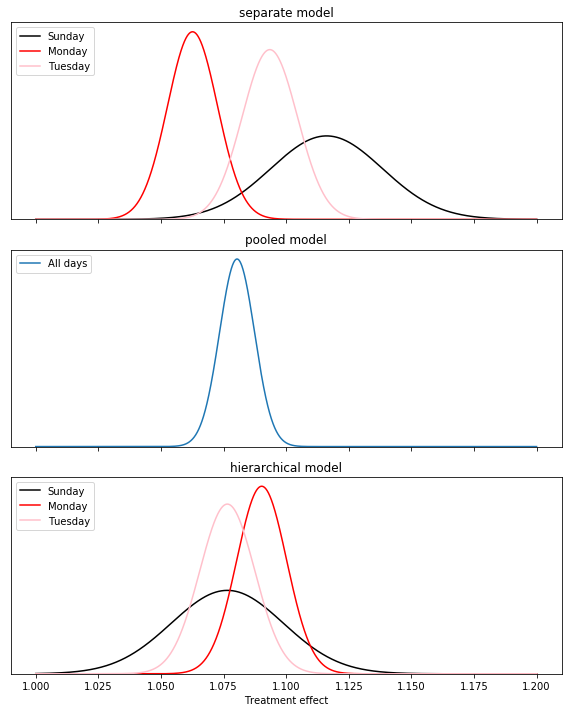

In [342]:
# plot the separate, pooled and hierarchical models
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 10))
x = np.linspace(1, 1.2, 20000)

# separate
ax = axes[0]
line1 = ax.plot(x, norm.pdf(x, Y[0], sigma[0]), color='black')
line2 = ax.plot(x, norm.pdf(x, Y[1], sigma[1]), color='red')
line3 = ax.plot(x, norm.pdf(x, Y[2], sigma[2]), color='pink')
ax.legend(('Sunday','Monday','Tuesday'),loc='upper left'
)
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# pooled
ax = axes[1]
ax.plot(
    x,
    norm.pdf(
        x,
        np.sum(Y/sigma**2)/np.sum(1/sigma**2),
        np.sqrt(1/np.sum(1/sigma**2))
    ),
    label='All days'
)
ax.legend(loc='upper left')
ax.set_yticks(())
ax.set_title('pooled model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# hierarchical
ax = axes[2]
line1 = ax.plot(x, norm.pdf(x, np.mean(theta_m1[0]), sigma[0]), color='black')
line2 = ax.plot(x, norm.pdf(x, np.mean(theta_m1[1]), sigma[1]), color='red')
line3 = ax.plot(x, norm.pdf(x, np.mean(theta_m1[2]), sigma[2]), color='pink')
ax.legend(('Sunday','Monday','Tuesday'),loc='upper left')
ax.set_yticks(())
ax.set_title('hierarchical model')
ax.set_xlabel('Treatment effect')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

In [343]:
op1 = sm1.optimizing(data=schools_dat)
print(op1)

OrderedDict([('mu', array(1.08039268)), ('tau', array(2.58102601e-15)), ('eta', array([-3.00570774e-08,  3.32015178e-07,  2.04616365e-07])), ('theta', array([1.08039268, 1.08039268, 1.08039268]))])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B2CE8E9D30>,
      dtype=object)

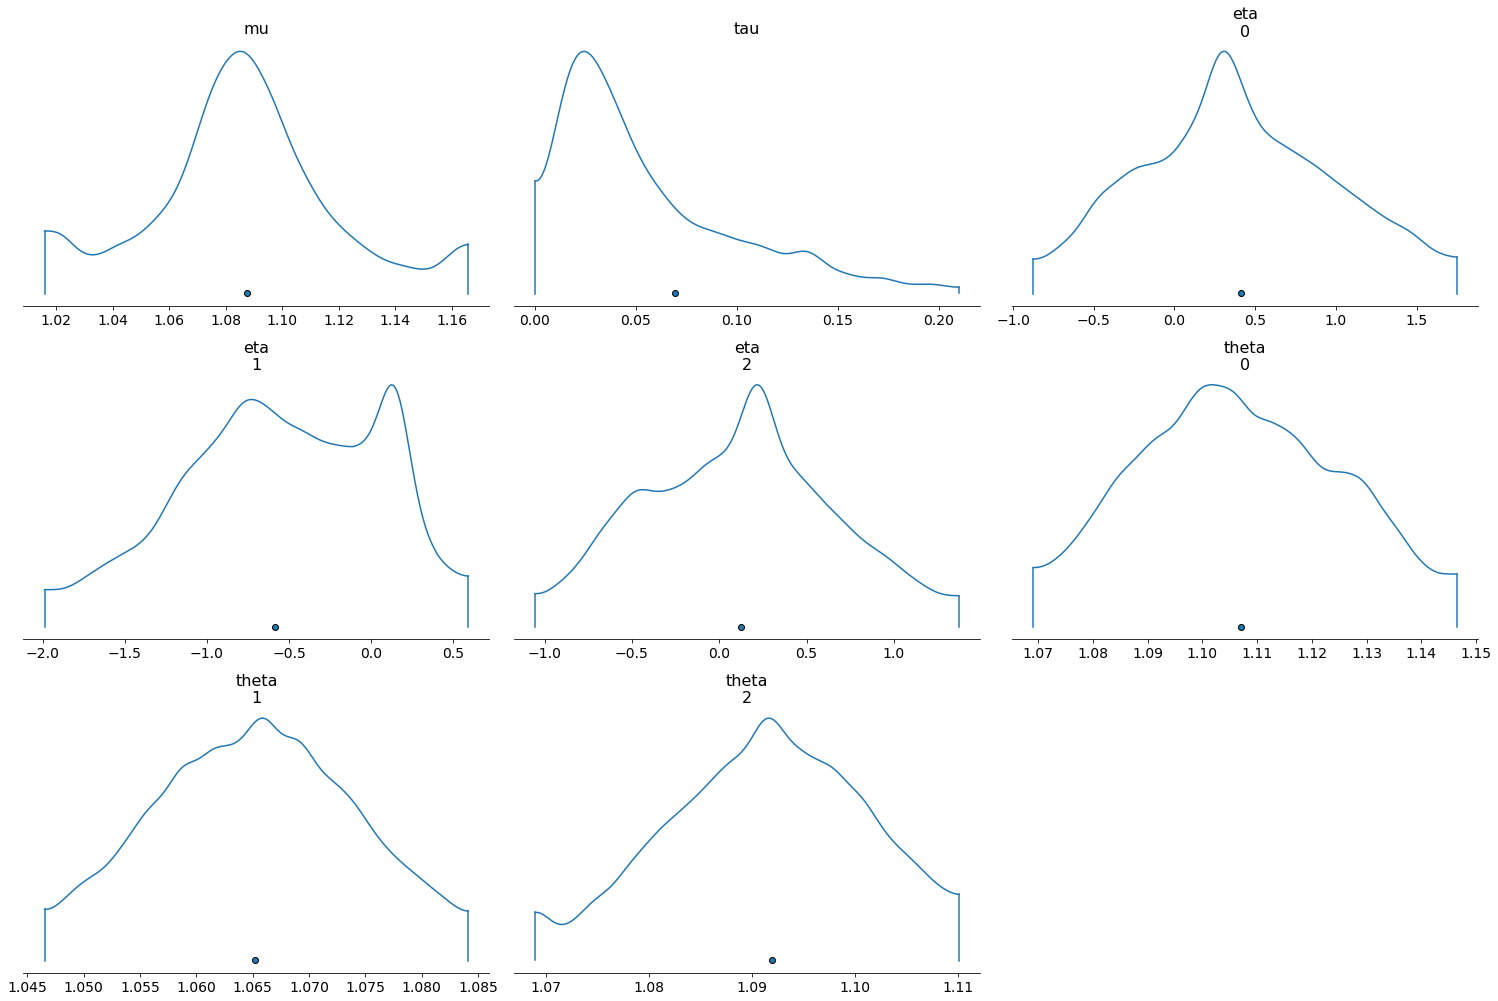

In [344]:
inf_m1_data = az.convert_to_inference_data(fit_m1)
az.plot_density(inf_m1_data)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.42626033e-02, 2.66230785e-01, 1.69836880e+00,
        7.11478823e+00, 1.35777700e+01, 2.35476539e+01, 3.23057287e+01,
        3.86585461e+01, 3.04788347e+01, 1.95909136e+01, 1.05115258e+01,
        4.07608513e+00, 1.37705579e+00, 2.75411157e-01, 5.50822314e-02,
        9.18037190e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([1.0248853 , 1.03033171, 1.03577811, 1.04122451, 1.04667091,
        1.05211732, 1.05756372, 1.06301012, 1.06845652, 1.07390293,
        1.07934933, 1.08479573, 1.09024213, 1.09568854, 1.10113494,
        1.10658134, 1.11202774, 1.11747415, 1.12292055, 1.12836695,
        1.13381335, 1.13925976, 1.14470616, 1.15015256, 1.15559896,
        1.16104537, 1.16649177, 1.17193817, 1.17738457, 1.18283098,
        1.18827738]),
 <a list of 30 Patch obj

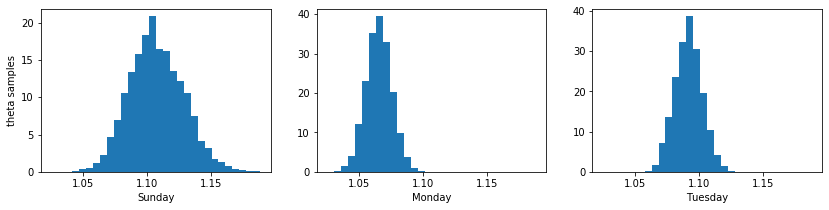

In [345]:
fig, ax = plt.subplots(1, 3, figsize=(14,3))
ax[0].set_ylabel("theta samples")
ax[0].set_xlabel("Sunday")
ax[1].set_xlabel("Monday")
ax[2].set_xlabel("Tuesday")
ax[0].hist(theta_m1[:,0], bins=30, density=True, range=(theta_m1.min(),theta_m1.max()))
ax[1].hist(theta_m1[:,1], bins=30, density=True, range=(theta_m1.min(),theta_m1.max()))
ax[2].hist(theta_m1[:,2], bins=30, density=True, range=(theta_m1.min(),theta_m1.max()))

In [346]:
df1 = pystan.misc.to_dataframe(fit_m1)
df1.to_csv("./results-Hier.csv", index=False)

# HW 3 - Exstanded Hier 

In [347]:
model_2 = """
data {
    int<lower=0> J; // number of days
    vector[J] y; // empirical means of rates in each day
    vector<lower=0>[J] sigma; // empirical standard deviation of rates in each day, as a true value
}
parameters {
    real<lower=0> x0;
    real<lower=0> x1;
    real<lower=0> g;
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    tau ~ cauchy(x0, g);
    g ~ gamma(0.5,1);
    x0 ~ normal(0,1.5);
    mu ~ gamma(x1, 5);
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

In [348]:
sm2 = pystan.StanModel(model_code=model_2)
fit_m2 = sm2.sampling(data=schools_dat, iter=10000, chains=4)
print(fit_m2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d0c37546fbcfd327cf7f2d345e46e4c NOW.


Inference for Stan model: anon_model_9d0c37546fbcfd327cf7f2d345e46e4c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x0         0.31  6.8e-3   0.43 7.3e-3   0.05   0.15   0.39    1.6   3896    1.0
x1         6.41    0.08    2.4   2.36   4.69   6.23   7.94  11.64    928   1.01
g          0.31  6.4e-3   0.48 8.7e-4   0.03   0.13   0.38   1.68   5781    1.0
mu         1.09  7.7e-3   0.06   0.98   1.07   1.09   1.11   1.29     70   1.06
tau        0.09  9.0e-3    0.1 6.3e-3   0.03   0.05    0.1   0.36    129   1.04
eta[1]      0.4    0.04   0.73  -0.89   -0.1   0.37   0.86   1.92    300   1.02
eta[2]    -0.55    0.01    0.7  -2.02  -0.98  -0.51  -0.06   0.71   2879    1.0
eta[3]     0.11    0.03   0.65  -1.06  -0.34    0.1   0.52   1.49    483   1.01
theta[1]   1.11  2.7e-4   0.02   1.07   1.09   1.11   1.12   1.15   6113    1.0
theta[2] 

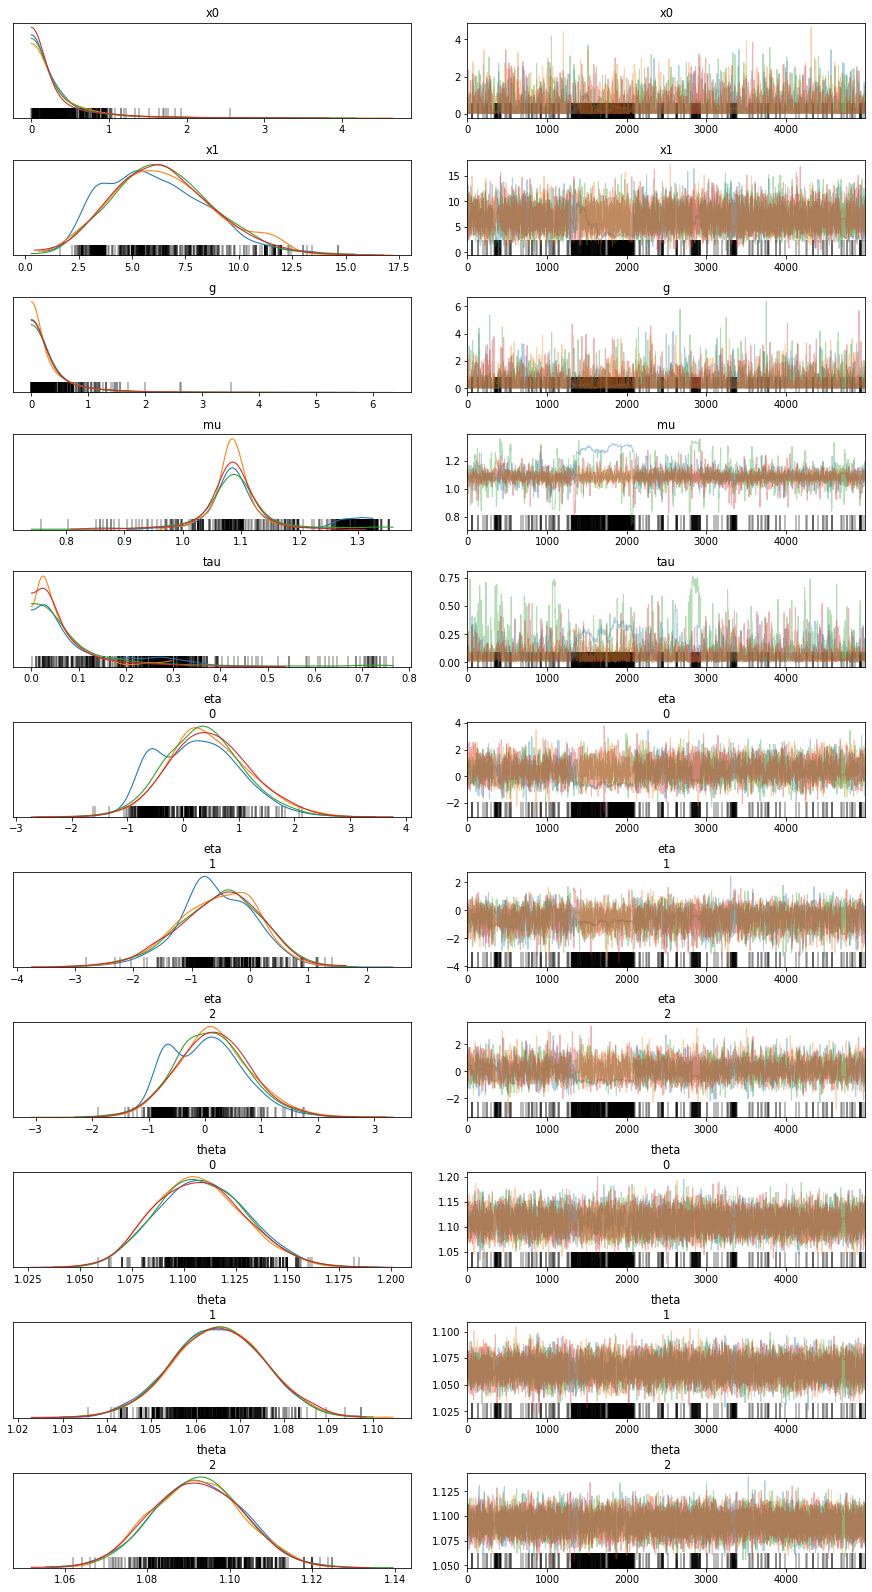

In [349]:
_ = az.plot_trace(fit_m2)

In [350]:
fit_m2.extract(permuted = True)
mu_m2 = np.array(fit_m2.extract()['mu'])
tau_m2 = np.array(fit_m2.extract()['tau'])
eta_m2 = np.array(fit_m2.extract()['eta'])
theta_m2 = np.array(fit_m2.extract()['theta'])
x0_m2 = np.array(fit_m2.extract()['x0'])
g_m2 = np.array(fit_m2.extract()['g'])
lp_m2 = np.array(fit_m2.extract()['lp__'])

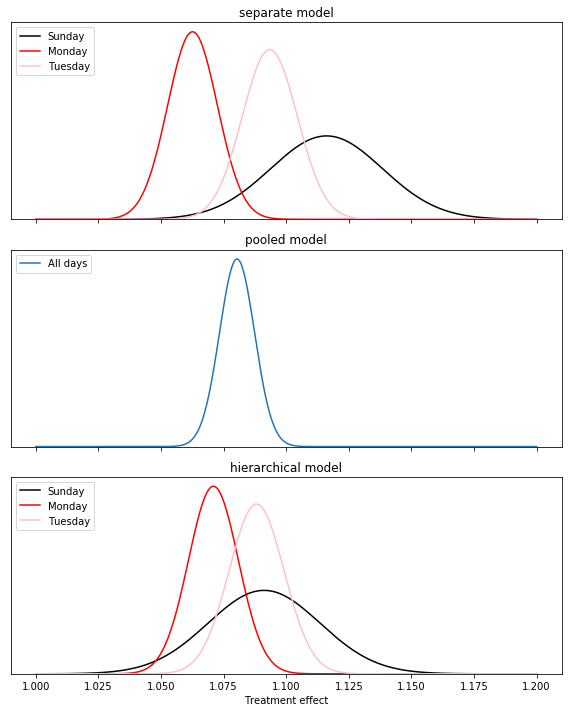

In [351]:
# plot the separate, pooled and hierarchical models
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 10))
x = np.linspace(1, 1.2, 20000)

# separate
ax = axes[0]
line1 = ax.plot(x, norm.pdf(x, Y[0], sigma[0]), color='black')
line2 = ax.plot(x, norm.pdf(x, Y[1], sigma[1]), color='red')
line3 = ax.plot(x, norm.pdf(x, Y[2], sigma[2]), color='pink')
ax.legend(('Sunday','Monday','Tuesday'),loc='upper left'
)
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# pooled
ax = axes[1]
ax.plot(
    x,
    norm.pdf(
        x,
        np.sum(Y/sigma**2)/np.sum(1/sigma**2),
        np.sqrt(1/np.sum(1/sigma**2))
    ),
    label='All days'
)
ax.legend(loc='upper left')
ax.set_yticks(())
ax.set_title('pooled model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# hierarchical
ax = axes[2]
line1 = ax.plot(x, norm.pdf(x, np.mean(theta_m2[0]), sigma[0]), color='black')
line2 = ax.plot(x, norm.pdf(x, np.mean(theta_m2[1]), sigma[1]), color='red')
line3 = ax.plot(x, norm.pdf(x, np.mean(theta_m2[2]), sigma[2]), color='pink')
ax.legend(('Sunday','Monday','Tuesday'),loc='upper left')
ax.set_yticks(())
ax.set_title('hierarchical model')
ax.set_xlabel('Treatment effect')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

In [355]:
op_m2 = sm2.optimizing(data=schools_dat)
print(op_m2)

OrderedDict([('x0', array(0.17814315)), ('x1', array(12.5964125)), ('g', array(3.33547755e-07)), ('mu', array(1.51402805)), ('tau', array(0.17814315)), ('eta', array([-2.15437972, -2.51237641, -2.40474066])), ('theta', array([1.13024007, 1.06646542, 1.08563999]))])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B2B919E278>,
      dtype=object)

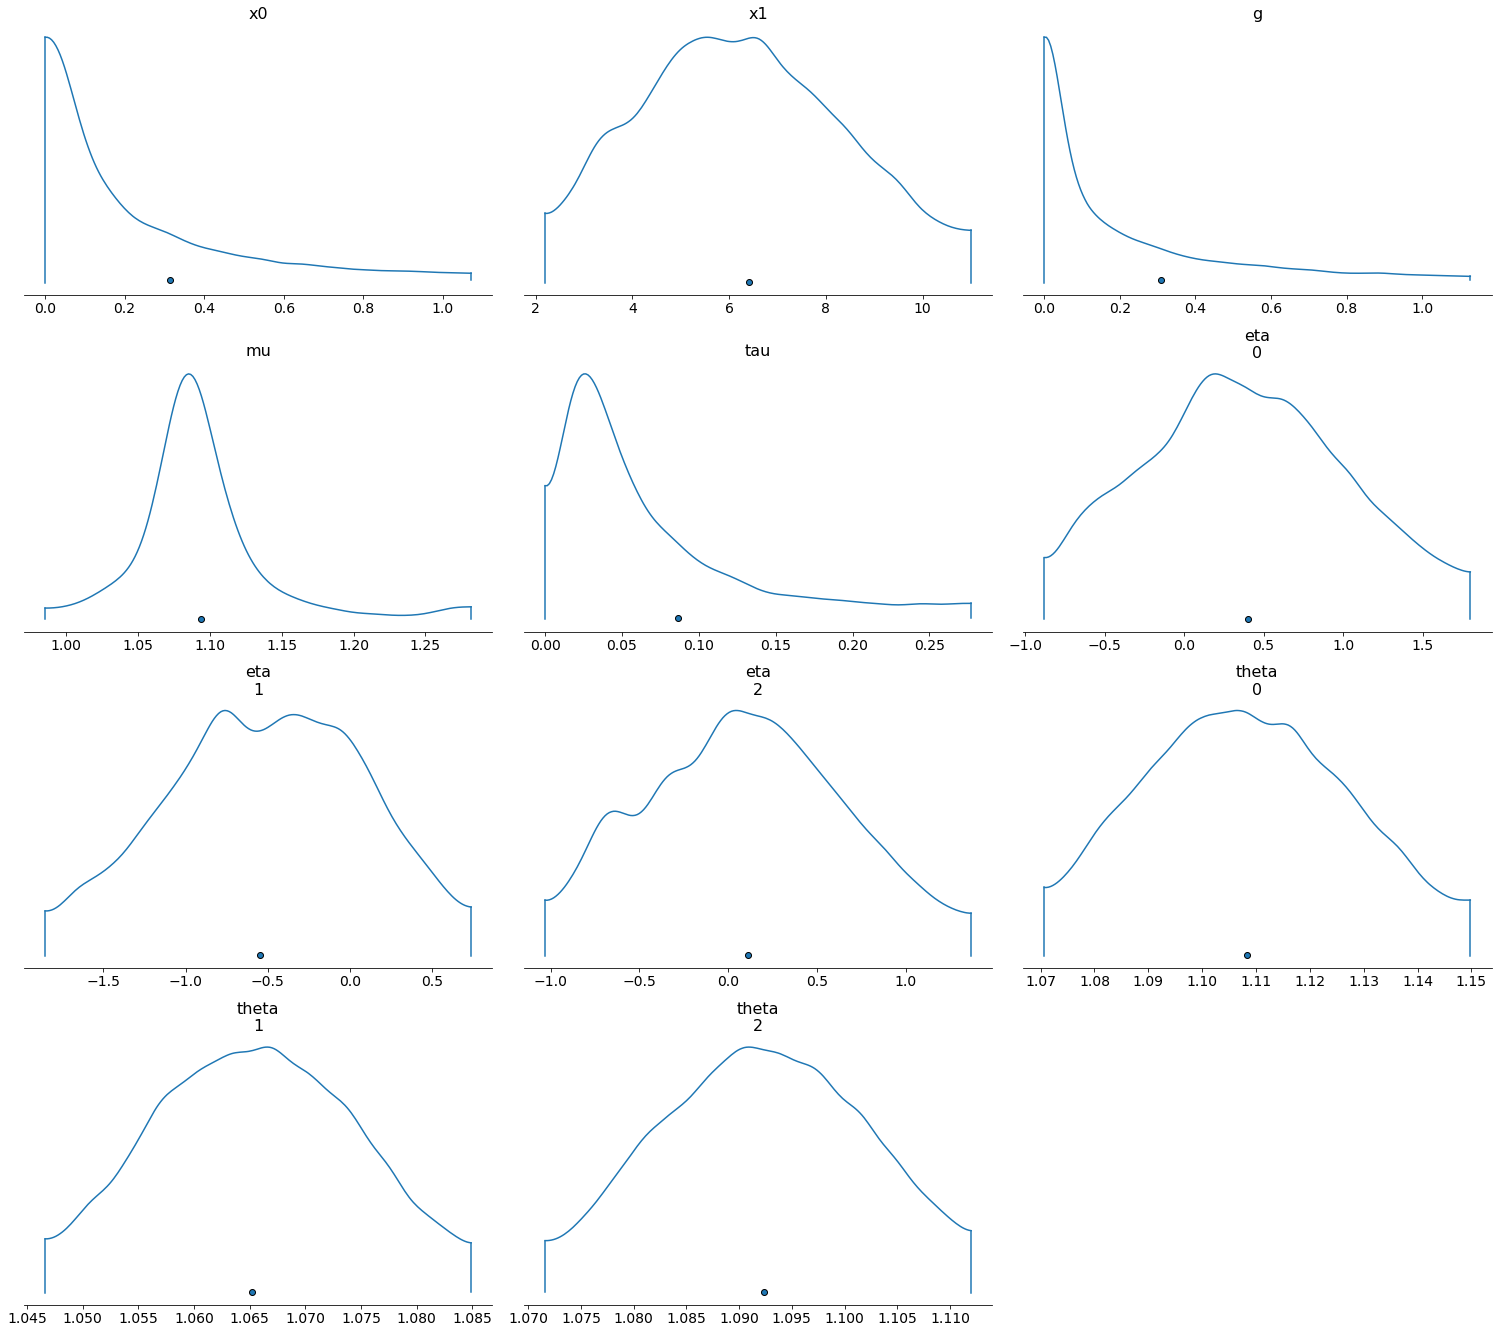

In [356]:
inf_m2_data = az.convert_to_inference_data(fit_m2)
az.plot_density(inf_m2_data)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.43560138e-03, 1.18098419e-01, 5.90492096e-01, 2.44632440e+00,
        8.44403698e+00, 1.92837847e+01, 2.86726091e+01, 3.56910294e+01,
        3.23336601e+01, 2.31051122e+01, 1.19701184e+01, 4.38651272e+00,
        1.24003340e+00, 3.54295258e-01, 5.90492096e-02, 8.43560138e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([1.02295011, 1.02887737, 1.03480463, 1.04073189, 1.04665915,
        1.05258641, 1.05851367, 1.06444093, 1.07036819, 1.07629545,
        1.08222271, 1.08814997, 1.09407723, 1.10000449, 1.10593175,
        1.11185901, 1.11778627, 1.12371353, 1.12964079, 1.13556805,
        1.14149531, 1.14742257, 1.15334983, 1.15927709, 1.16520435,
        1.17113161, 1.17705887, 1.18298613, 1.18891339, 1.19484064,
        1.2007679 ]),
 <a list of 30 Patch obj

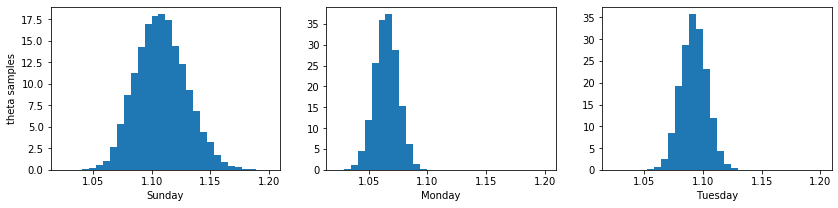

In [357]:
fig, ax = plt.subplots(1, 3, figsize=(14,3))
ax[0].set_ylabel("theta samples")
ax[0].set_xlabel("Sunday")
ax[1].set_xlabel("Monday")
ax[2].set_xlabel("Tuesday")
ax[0].hist(theta_m2[:,0], bins=30, density=True, range=(theta_m2.min(),theta_m2.max()))
ax[1].hist(theta_m2[:,1], bins=30, density=True, range=(theta_m2.min(),theta_m2.max()))
ax[2].hist(theta_m2[:,2], bins=30, density=True, range=(theta_m2.min(),theta_m2.max()))

In [358]:
df2 = pystan.misc.to_dataframe(fit_m2)
df2.to_csv("./results-ExstandHier.csv", index=False)

# HW3 - Model checking and evaluation

Text(0.5, 0, 'observations')

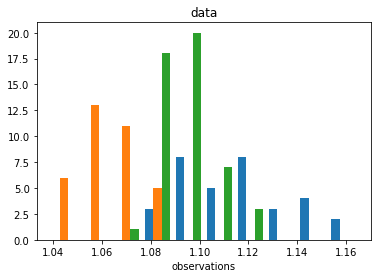

In [359]:
data_sun = np.array(days['Sunday'])
data_mon = np.array(days['Monday'])
data_tue = np.array(days['Tuesday'])
data = np.array([data_sun,data_mon,data_tue])
_ = plt.hist(data)
plt.title("data")
plt.xlabel("observations")

### save models samples

In [360]:
samples_m1 = theta_m1.T
samples_sensitivity_m1 = tau_m1.T
np.save('m1_tau_7.npy', samples_m1) 
print("samples_1 shape:", samples_m1.shape)

samples_m2 = theta_m2.T
samples_sensitivity_m2 = x0_m2.T
np.save('m2_x0_7.npy', samples_m2) 
print("samples_2 shape:", samples_m2.shape)

SAMPLES = []
SAMPLES.append(['model_1',samples_m1.T,_])
SAMPLES.append(['model_2',samples_m2.T,_])

SAMPLES_SENS = []
SAMPLES_SENS.append(['model_1',samples_sensitivity_m1.T,'tau'])
SAMPLES_SENS.append(['model_2',samples_sensitivity_m2.T,'x0'])

samples_1 shape: (3, 20000)
samples_2 shape: (3, 20000)


### Here we plot the posterior distribution of the log predictive density log p(y|theta).

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.43560138e-03, 1.18098419e-01, 5.90492096e-01, 2.44632440e+00,
        8.44403698e+00, 1.92837847e+01, 2.86726091e+01, 3.56910294e+01,
        3.23336601e+01, 2.31051122e+01, 1.19701184e+01, 4.38651272e+00,
        1.24003340e+00, 3.54295258e-01, 5.90492096e-02, 8.43560138e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([1.02295011, 1.02887737, 1.03480463, 1.04073189, 1.04665915,
        1.05258641, 1.05851367, 1.06444093, 1.07036819, 1.07629545,
        1.08222271, 1.08814997, 1.09407723, 1.10000449, 1.10593175,
        1.11185901, 1.11778627, 1.12371353, 1.12964079, 1.13556805,
        1.14149531, 1.14742257, 1.15334983, 1.15927709, 1.16520435,
        1.17113161, 1.17705887, 1.18298613, 1.18891339, 1.19484064,
        1.2007679 ]),
 <a list of 30 Patch obj

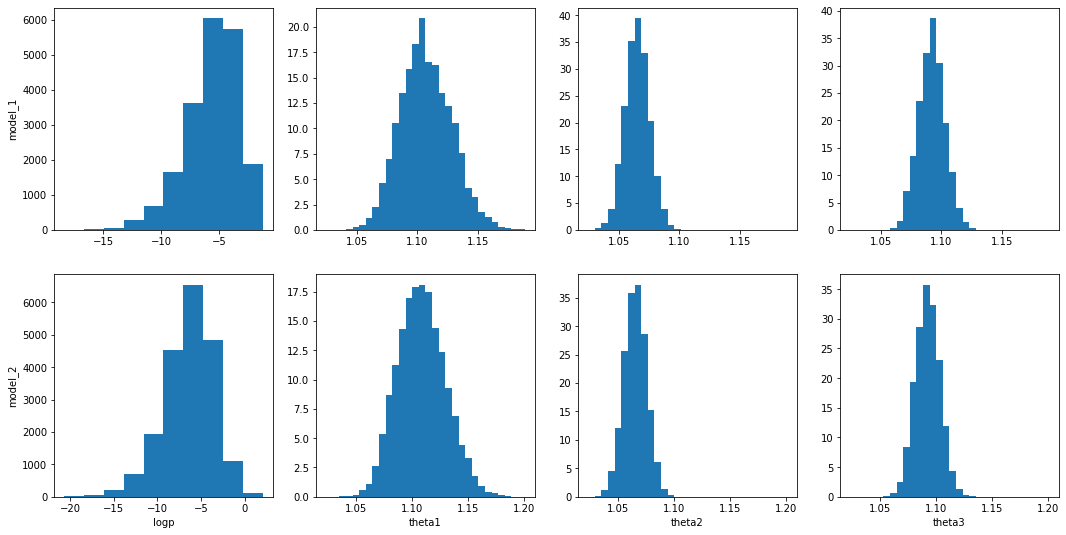

In [361]:
fig, ax = plt.subplots(2,4, figsize=(18, 9))
ax[1][0].set_xlabel("logp")
ax[1][1].set_xlabel("theta1")
ax[1][2].set_xlabel("theta2")
ax[1][3].set_xlabel("theta3")
ax[0][0].set_ylabel("model_1")
ax[0][0].hist(lp_m1)
ax[0][1].hist(samples_m1[0], bins=30, density=True, range=(samples_m1.min(),samples_m1.max()))
ax[0][2].hist(samples_m1[1], bins=30, density=True, range=(samples_m1.min(),samples_m1.max()))
ax[0][3].hist(samples_m1[2], bins=30, density=True, range=(samples_m1.min(),samples_m1.max()))
ax[1][0].set_ylabel("model_2")
ax[1][0].hist(lp_m2)
ax[1][1].hist(samples_m2[0], bins=30, density=True, range=(samples_m2.min(),samples_m2.max()))
ax[1][2].hist(samples_m2[1], bins=30, density=True, range=(samples_m2.min(),samples_m2.max()))
ax[1][3].hist(samples_m2[2], bins=30, density=True, range=(samples_m2.min(),samples_m2.max()))

In [362]:
dataMin, dataMax, dataMedian = Y.min(), Y.max(), np.median(Y)
print(f"min:\t{dataMin:.3f}\nmax:\t{dataMax:.3f}\nmedian:\t{dataMedian:.3f}\n")

min:	1.063
max:	1.116
median:	1.093



In [363]:
def simulate(samples, nobs=len(samples_m1.T)):
        simulations = []
        for i in range(nobs):
            thetas = samples[i,:]
            y_rep = []
            for j in range(3):
                y_rep.append(np.random.normal(thetas[j], sigma[j], 1)[0])
            simulations.append(y_rep)
        return np.array(simulations)

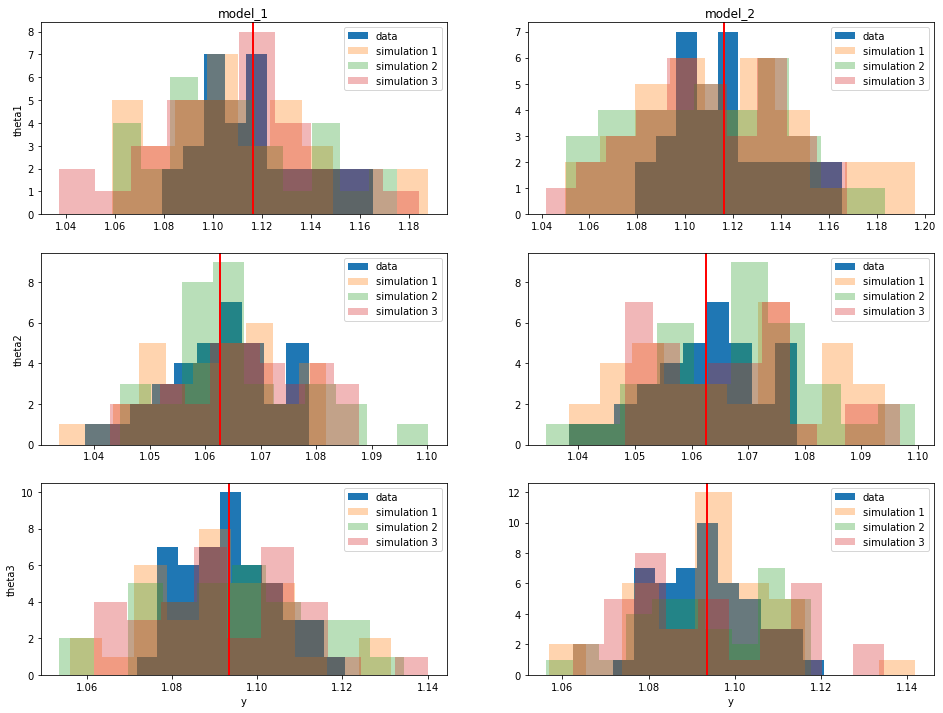

In [364]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[0][i].set_title(model)
    ax[-1][i].set_xlabel("y")
    ax[0][i].hist(data[0], label="data",range=(data[0].min(),data[0].max()))
    ax[1][i].hist(data[1], label="data",range=(data[1].min(),data[1].max()))
    ax[2][i].hist(data[2], label="data",range=(data[2].min(),data[2].max()))
    for j in range(3):
        ax[j][0].set_ylabel("theta"+str(j+1))
        simulations = simulate(samples, len(data[i]))
        for k in range(0,3):
            ax[k][i].hist(simulations[:,k], alpha=0.33, label="simulation "+str(j+1),range=(simulations[:,k].min(),simulations[:,k].max()))
            ax[k][i].axvline(Y[k], color="red")
    ax[0][i].legend()
    ax[1][i].legend()
    ax[2][i].legend()

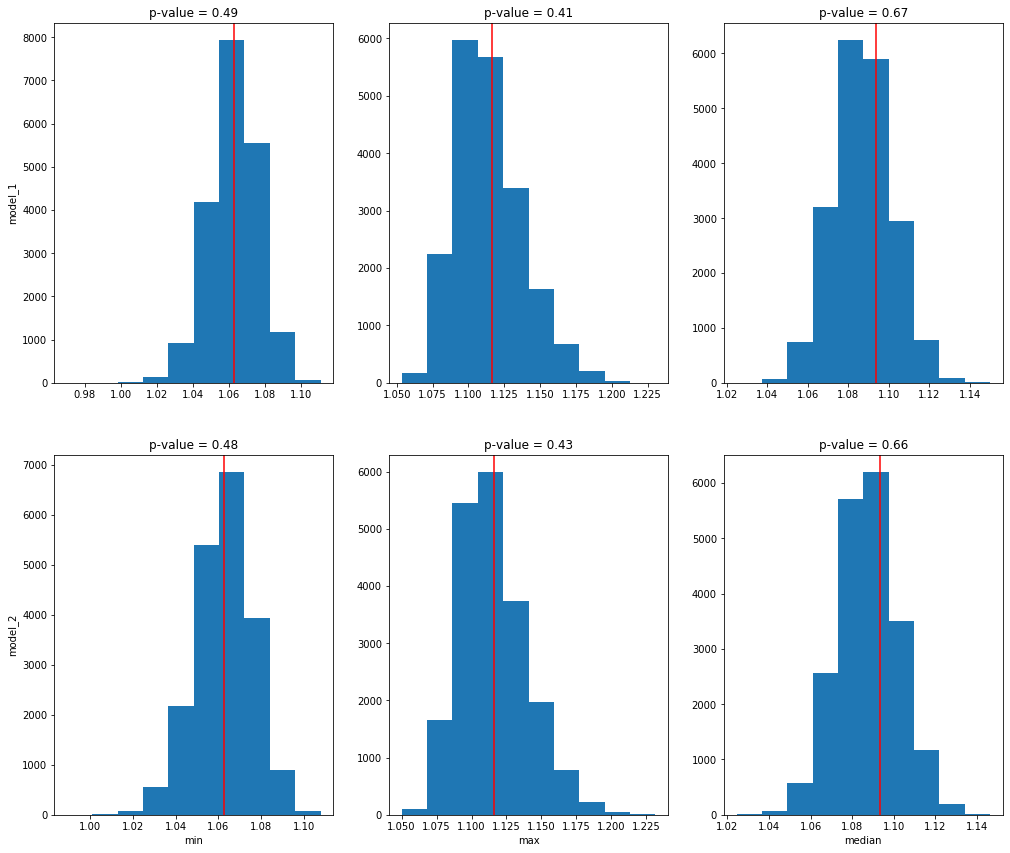

In [365]:
fig, ax = plt.subplots(2, 3, figsize=(17, 8))
fig.subplots_adjust(top=1.5)
ax[-1][0].set_xlabel("min")
ax[-1][1].set_xlabel("max")
ax[-1][2].set_xlabel("median")
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    y = simulate(samples)
    min_rep = np.min(y, axis=1)
    max_rep = np.max(y, axis=1)
    median_rep = np.median(y, axis=1) 

    ax[i][0].axvline(dataMin, color="red")
    ax[i][1].axvline(dataMax, color="red")
    ax[i][2].axvline(dataMedian, color="red")

    ax[i][0].hist(min_rep, zorder=-1)
    ax[i][1].hist(max_rep, zorder=-1)
    ax[i][2].hist(median_rep, zorder=-1)

    ax[i][0].set_title("p-value = {:.2f}".format(
        len(min_rep[min_rep < dataMin]) /
        len(min_rep)))
    ax[i][1].set_title("p-value = {:.2f}".format(
        len(max_rep[max_rep > dataMax]) /
        len(max_rep)))
    ax[i][2].set_title("p-value = {:.2f}".format(
        len(median_rep[median_rep < dataMedian]) /
        len(median_rep)))

### Sensitivity Analysis

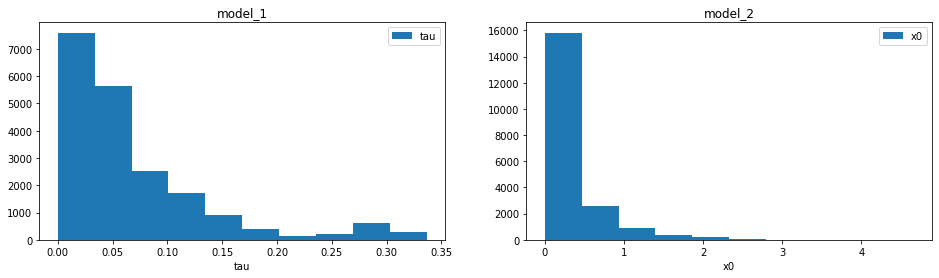

In [656]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].set_xlabel("tau")
ax[1].set_xlabel("x0")
for i, (model, samples, param) in enumerate(SAMPLES_SENS):
    ax[i].set_title(model)
    ax[i].hist(samples, label=str(param))       
    ax[i].legend()

In [894]:
tau_model1 = SAMPLES_SENS[0][1]
x0_model2 = SAMPLES_SENS[1][1]

tau_model1 = np.round(tau_model1,3)
x0_model2 = np.round(x0_model2,3)

counts_tau, bins_tau = np.histogram(tau_model1, 8)
counts_x0, bins_x0 = np.histogram(x0_model2, 8)

tau_model1_test = np.zeros(tau_model1.shape)
x0_model2_test = np.zeros(x0_model2.shape)

for i in range(0,tau_model1.shape[0]): 
    for j in range (0, bins_tau.shape[0]-1):
        if bins_tau[j] <= tau_model1[i] <= bins_tau[j+1]:
            tau_model1_test[i] = bins_tau[j+1]
        if bins_x0[j] <= x0_model2[i] <= bins_x0[j+1]:
            x0_model2_test[i] = bins_x0[j+1]

In [895]:
theta1_m1 = SAMPLES[0][1][:,0]
theta2_m1 = SAMPLES[0][1][:,1]
theta3_m1 = SAMPLES[0][1][:,2]
theta1_m2 = SAMPLES[0][1][:,0]
theta2_m2 = SAMPLES[0][1][:,1]
theta3_m2 = SAMPLES[0][1][:,2]

In [896]:
theta1_m1_mean = np.zeros(len(counts_tau))
theta1_m1_std = np.zeros(len(counts_tau))

theta2_m1_mean = np.zeros(len(counts_tau))
theta2_m1_std = np.zeros(len(counts_tau))

theta3_m1_mean = np.zeros(len(counts_tau))
theta3_m1_std = np.zeros(len(counts_tau))

theta1_m2_mean = np.zeros(len(counts_x0))
theta1_m2_std = np.zeros(len(counts_x0))

theta2_m2_mean = np.zeros(len(counts_x0))
theta2_m2_std = np.zeros(len(counts_x0))

theta3_m2_mean = np.zeros(len(counts_x0))
theta3_m2_std = np.zeros(len(counts_x0))

for i in range(0,len(counts_tau)):
    theta1_m1_mean[i] = np.mean(theta1_m1[tau_model1_test == bins_tau[i]])
    theta1_m1_std[i] = np.std(theta1_m1[tau_model1_test == bins_tau[i]])
    
    theta2_m1_mean[i] = np.mean(theta2_m1[tau_model1_test == bins_tau[i]])
    theta2_m1_std[i] = np.std(theta2_m1[tau_model1_test == bins_tau[i]])
    
    theta3_m1_mean[i] = np.mean(theta3_m1[tau_model1_test == bins_tau[i]])
    theta3_m1_std[i] = np.std(theta3_m1[tau_model1_test == bins_tau[i]])
    
    theta1_m2_mean[i] = np.mean(theta1_m2[x0_model2_test == bins_x0[i]])
    theta1_m2_std[i] = np.std(theta1_m2[x0_model2_test == bins_x0[i]])

    theta2_m2_mean[i] = np.mean(theta2_m2[x0_model2_test == bins_x0[i]])
    theta2_m2_std[i] = np.std(theta2_m2[x0_model2_test == bins_x0[i]])

    theta3_m2_mean[i] = np.mean(theta3_m2[x0_model2_test == bins_x0[i]])
    theta3_m2_std[i] = np.std(theta3_m2[x0_model2_test == bins_x0[i]])

In [897]:
theta1_m1_mean = np.nan_to_num(theta1_m1_mean[1:])
theta1_m1_std = np.nan_to_num(theta1_m1_std[1:]) * 10**11

theta2_m1_mean = np.nan_to_num(theta2_m1_mean[1:])
theta2_m1_std = np.nan_to_num(theta2_m1_std[1:]) * 10**11

theta3_m1_mean = np.nan_to_num(theta3_m1_mean[1:])
theta3_m1_std = np.nan_to_num(theta3_m1_std[1:]) * 10**11

theta1_m2_mean = np.nan_to_num(theta1_m2_mean[1:])
theta1_m2_std = np.nan_to_num(theta1_m2_std[1:]) * 10**11

theta2_m2_mean = np.nan_to_num(theta2_m2_mean[1:])
theta2_m2_std = np.nan_to_num(theta2_m2_std[1:]) * 10**11

theta3_m2_mean = np.nan_to_num(theta3_m2_mean[1:])
theta3_m2_std = np.nan_to_num(theta3_m2_std[1:]) * 10**11

In [898]:
print(theta1_m1_mean)

[1.1003459  1.11248704 1.11543339 1.11231206 1.1110542  1.1174617
 1.11247929]


In [899]:
colors_list = list(colors._colors_full_map.values())
data3 = ['Sunday','Monday', 'Tuesday']

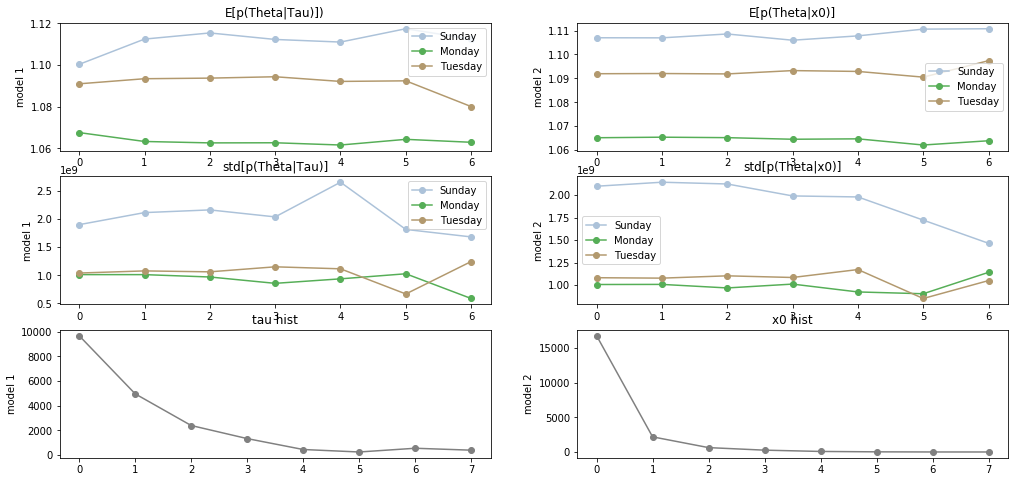

In [915]:
length = 7

fig, ax = plt.subplots(3, 2, figsize=(17, 8))

ax[0][0].set_title('E[p(Theta|Tau)])')
ax[1][0].set_title('std[p(Theta|Tau)]')
ax[0][1].set_title('E[p(Theta|x0)]')
ax[1][1].set_title('std[p(Theta|x0)]')
ax[2][0].set_title('tau hist')
ax[2][1].set_title('x0 hist')
ax[0][0].set_ylabel('model 1')
ax[1][0].set_ylabel('model 1')
ax[0][1].set_ylabel('model 2')
ax[1][1].set_ylabel('model 2')
ax[2][0].set_ylabel('model 1')
ax[2][1].set_ylabel('model 2')

ax[0][0].plot(range(length),theta1_m1_mean,marker='o',color=colors_list[0],label=str(data3[0]))
ax[0][0].plot(range(length),theta2_m1_mean,marker='o',color=colors_list[1],label=str(data3[1]))
ax[0][0].plot(range(length),theta3_m1_mean,marker='o',color=colors_list[2],label=str(data3[2]))

ax[0][1].plot(range(length),theta1_m2_mean,marker='o',color=colors_list[0],label=str(data3[0]))
ax[0][1].plot(range(length),theta2_m2_mean,marker='o',color=colors_list[1],label=str(data3[1]))
ax[0][1].plot(range(length),theta3_m2_mean,marker='o',color=colors_list[2],label=str(data3[2]))

ax[1][0].plot(range(length),theta1_m1_std,marker='o',color=colors_list[0],label=str(data3[0]))
ax[1][0].plot(range(length),theta2_m1_std,marker='o',color=colors_list[1],label=str(data3[1]))
ax[1][0].plot(range(length),theta3_m1_std,marker='o',color=colors_list[2],label=str(data3[2]))

ax[1][1].plot(range(length),theta1_m2_std,marker='o',color=colors_list[0],label=str(data3[0]))
ax[1][1].plot(range(length),theta2_m2_std,marker='o',color=colors_list[1],label=str(data3[1]))
ax[1][1].plot(range(length),theta3_m2_std,marker='o',color=colors_list[2],label=str(data3[2]))

ax[2][0].plot(range(8),counts_tau,marker='o',color='gray',label='tau')
ax[2][1].plot(range(8),counts_x0,marker='o',color='gray',label='x0')

ax[0][0].legend()
ax[1][0].legend()
ax[0][1].legend()
ax[1][1].legend()


In [916]:
def compute_lppd(samples):               
    lppd = 0
    print(samples.shape)
    for i in range(3):  
        tmp_sum = 0
        for j, sample in enumerate(samples): 
            test = norm.pdf((Y[i]- sample[i]) / sigma[i])
            test = test / sigma[i]
            tmp_sum = tmp_sum + test
        lppd = lppd + np.log(tmp_sum / samples.shape[0])
    return lppd

In [917]:
lppd_1 = compute_lppd(theta_m1)
lppd_2 = compute_lppd(theta_m2)

(20000, 3)
(20000, 3)


In [918]:
print("-2 *model 1: ", -2 *lppd_1)
print("-2 *model 2: ", -2 *lppd_2)

-2 *model 1:  -18.160253854547744
-2 *model 2:  -18.140407720518475


In [919]:
def pWAIC1(samples):              
    res = 0
    for i in range(3):  
        sum1 = 0
        sum2 = 0
        for j, sample in enumerate(samples): 
            sum1 = sum1 + norm.pdf(Y[i], sample[i], sigma[i])
            sum2 = sum2 + np.log(norm.pdf(Y[i], sample[i], sigma[i]))           
        res = res + np.log(sum1 / samples.shape[0]) - (sum2 / samples.shape[0])
    return 2 * res

In [920]:
def pWAIC2(samples):
    avg = []
    for i in range(3):
        tmp_sum = 0
        tmp_cnt = 0
        for j, sample in enumerate(samples):  
            tmp_sum = tmp_sum + np.log(norm.pdf(Y[i], sample[i], sigma[i]))
            tmp_cnt = tmp_cnt + 1
        avg.append(tmp_sum/tmp_cnt)
    res = 0
    for i in range(3):  
        tmp_sum = 0
        for j, sample in enumerate(samples):  
            tmp_sum = tmp_sum + ((np.log(norm.pdf(Y[i], sample[i], sigma[i])) - avg[i]) ** 2)
        res = res + ((1/(samples.shape[0]-1)) * tmp_sum)
    return 2 * res

In [921]:
pWAIC1_m1 = pWAIC1(theta_m1)
pWAIC1_m2 = pWAIC1(theta_m2)
pWAIC2_m1 = pWAIC2(theta_m1)
pWAIC2_m2 = pWAIC2(theta_m2)
WAIC_1 = -2 * (lppd_1 - pWAIC2_m1)
WAIC_2 = -2 * (lppd_2 - pWAIC2_m1)

print("pWAIC 1 of model 1: ", pWAIC1_m1)
print("pWAIC 1 of model 2: ", pWAIC1_m2)
print("pWAIC 2 of model 1: ", pWAIC2_m1)
print("pWAIC 2 of model 2: ", pWAIC2_m2)
print("WAIC of model 1: ", WAIC_1)
print("WAIC of model 2: ", WAIC_2)

pWAIC 1 of model 1:  0.955053384886198
pWAIC 1 of model 2:  0.9487756527843034
pWAIC 2 of model 1:  3.0467574154432158
pWAIC 2 of model 2:  3.032764189931772
WAIC of model 1:  -12.066739023661313
WAIC of model 2:  -12.046892889632044
